# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'jitter'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

In [6]:
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,341736.000000,341736.000000,3.417360e+05,3.417360e+05,3.417360e+05
mean,3297.084510,284.493392,1.616547e-08,1.729086e-10,4.172296e+01
std,1787.420224,12.444296,3.040603e-06,3.160590e-08,3.824214e+01
min,80.215370,249.496434,0.000000e+00,0.000000e+00,1.585317e-14
25%,1488.666795,274.942441,0.000000e+00,0.000000e+00,2.442180e+00
50%,3605.163780,287.485713,0.000000e+00,0.000000e+00,3.064934e+01
75%,4902.021024,295.257689,9.039629e-36,2.611568e-37,8.628855e+01
max,6862.129388,304.725510,1.481370e-03,1.521341e-05,9.474959e+01


In [7]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Train and Test Baseline Model

### Set Hyperparameters and Features

In [8]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [9]:
results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.3724797283113003
Training Loss: 0.2587138967216015
Training Loss: 0.15787248089909553
Validation Loss: 0.08384611980801218
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08787313522771001
Training Loss: 0.07890509041026235
Training Loss: 0.07299171866849065
Validation Loss: 0.06069226650876945
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06708046006038786
Training Loss: 0.06447082148864865
Training Loss: 0.061691562850028275
Validation Loss: 0.05300344673267911
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.057565800212323666
Training Loss: 0.055322766341269015
Training Loss: 0.0531382723711431
Validation Loss: 0.04571915677424227
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.0489798968937248
Training Loss: 0.04631241998635233
Training Loss:

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive_evaluation.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [02:26<21:59, 146.57s/it]

Training Loss: 0.00629215789551381
Validation Loss: 0.00321597727067936
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.23386890914291145
Training Loss: 0.18426533553749322
Training Loss: 0.13528615292161703
Validation Loss: 0.07312273376443412
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0760305593162775
Training Loss: 0.06582265708595514
Training Loss: 0.06297634176909923
Validation Loss: 0.05633356267314279
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.059089006055146456
Training Loss: 0.05724076692014932
Training Loss: 0.05556911915540695
Validation Loss: 0.04898688316428929
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05178409429267049
Training Loss: 0.04966281745582819
Training Loss: 0.04805785190314055
Validation Loss: 0.04120179240623217
Validation Accuracy:

 20%|██        | 2/10 [04:50<19:21, 145.21s/it]

Training Loss: 0.005954416222521104
Validation Loss: 0.0031271292160924397
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1045730141364038
Training Loss: 0.08326114177703857
Training Loss: 0.07165061248466373
Validation Loss: 0.06454173806175757
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06529859201982617
Training Loss: 0.06433481255546213
Training Loss: 0.06321752754971385
Validation Loss: 0.059780003398321985
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.060691477283835414
Training Loss: 0.059148370698094366
Training Loss: 0.05748381156474352
Validation Loss: 0.053322789395290816
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.053601124584674836
Training Loss: 0.05106382979080081
Training Loss: 0.048894291911274194
Validation Loss: 0.04409712435824148
Validation A

 30%|███       | 3/10 [07:15<16:54, 144.96s/it]

Training Loss: 0.006183336318936199
Validation Loss: 0.003255990078787874
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8081794127821922
Training Loss: 0.6841780990362167
Training Loss: 0.5582806667685509
Validation Loss: 0.43424925141120224
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3725827119499445
Training Loss: 0.2783579232543707
Training Loss: 0.1969282991439104
Validation Loss: 0.12728390449218535
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.11337296852841973
Training Loss: 0.08829233273863793
Training Loss: 0.0737121613137424
Validation Loss: 0.060765917130400623
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0660475017875433
Training Loss: 0.06518174398690463
Training Loss: 0.0644169488362968
Validation Loss: 0.05786361260695404
Validation Accuracy: 0.0
*

 40%|████      | 4/10 [09:39<14:28, 144.76s/it]

Training Loss: 0.006624870589002967
Validation Loss: 0.003669477714058221
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.22969355762004853
Training Loss: 0.1614959966018796
Training Loss: 0.11264144640415907
Validation Loss: 0.07839036456654581
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06979629997164011
Training Loss: 0.061130773797631266
Training Loss: 0.057895087003707886
Validation Loss: 0.05383797061074985
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.054797751847654584
Training Loss: 0.05333465356379748
Training Loss: 0.05235098673030734
Validation Loss: 0.048651394800523697
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.049230403648689386
Training Loss: 0.047310291128233074
Training Loss: 0.046270131589844825
Validation Loss: 0.042780282268865724
Validation 

 50%|█████     | 5/10 [12:04<12:03, 144.60s/it]

Training Loss: 0.006023065958870575
Validation Loss: 0.0031152359240039598
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.653823484480381
Training Loss: 0.5398627331852913
Training Loss: 0.4403177371621132
Validation Loss: 0.3450091631894701
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3097145490348339
Training Loss: 0.25108740612864494
Training Loss: 0.20116406843066215
Validation Loss: 0.1538651345318623
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.14236612778156996
Training Loss: 0.12029015507549047
Training Loss: 0.1008504942432046
Validation Loss: 0.08048582935098851
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07747407872229814
Training Loss: 0.0701410749182105
Training Loss: 0.0645571319758892
Validation Loss: 0.05764615544107523
Validation Accuracy: 0.0
**

 60%|██████    | 6/10 [14:29<09:38, 144.68s/it]

Training Loss: 0.005770956035703421
Validation Loss: 0.0028192479702319655
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6733226613700389
Training Loss: 0.6012000688910484
Training Loss: 0.5130564597249031
Validation Loss: 0.37748258502295845
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.33157105088233946
Training Loss: 0.214425982683897
Training Loss: 0.12853469662368297
Validation Loss: 0.07420673137635328
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.078574357368052
Training Loss: 0.07193578900769353
Training Loss: 0.06898421406745911
Validation Loss: 0.060100454272011695
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06646568184718489
Training Loss: 0.06524996273219585
Training Loss: 0.06412996714934707
Validation Loss: 0.05655135381757544
Validation Accuracy: 0.

 70%|███████   | 7/10 [16:53<07:14, 144.75s/it]

Training Loss: 0.006169200544245541
Validation Loss: 0.0031986577309448313
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.182696676813066
Training Loss: 0.14015614684671163
Training Loss: 0.0992707716114819
Validation Loss: 0.06719352187735311
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06765807552263141
Training Loss: 0.06434168759733438
Training Loss: 0.0626331977546215
Validation Loss: 0.06031063613429498
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058931391425430774
Training Loss: 0.057036374490708114
Training Loss: 0.05517872439697385
Validation Loss: 0.052603770089283415
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05050677918829024
Training Loss: 0.04777972253970802
Training Loss: 0.045267654955387114
Validation Loss: 0.04177781175612734
Validation Accura

 80%|████████  | 8/10 [19:18<04:49, 144.75s/it]

Training Loss: 0.006028603524900973
Validation Loss: 0.003018679150270319
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5643742461502552
Training Loss: 0.49886204540729523
Training Loss: 0.4404246096313
Validation Loss: 0.3830808514959357
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.33587124064564705
Training Loss: 0.2551922767609358
Training Loss: 0.16560407001525163
Validation Loss: 0.10263795037282987
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08779183024540543
Training Loss: 0.07379554899409413
Training Loss: 0.06771226823329926
Validation Loss: 0.06287979271807027
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06393196515738964
Training Loss: 0.06294741172343493
Training Loss: 0.061547244898974895
Validation Loss: 0.05773837525355682
Validation Accuracy: 0.0

 90%|█████████ | 9/10 [21:43<02:24, 144.85s/it]

Validation Loss: 0.0023980369304798625
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5628150989115238
Training Loss: 0.43760766252875327
Training Loss: 0.30328538186848164
Validation Loss: 0.1558233756530151
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12008180791512131
Training Loss: 0.07388494988903403
Training Loss: 0.06146803373470902
Validation Loss: 0.05159084327267797
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05661014917306602
Training Loss: 0.054122989680618044
Training Loss: 0.052495534904301165
Validation Loss: 0.0454920989701922
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04835805653594434
Training Loss: 0.04554391168057918
Training Loss: 0.04413143246434629
Validation Loss: 0.03886602590844203
Validation Accuracy: 0.0
*****************************

100%|██████████| 10/10 [24:08<00:00, 144.84s/it]


Validation Loss: 0.0030173169111498118
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.8107583779096603
Training Loss: 0.6450993630290032
Training Loss: 0.47566025868058204
Validation Loss: 0.3314371321643336
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.2542605239525437
Training Loss: 0.1338967963308096
Training Loss: 0.07625713985413313
Validation Loss: 0.06710791359707881
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06368175594136119
Training Loss: 0.06040060788393021
Training Loss: 0.05749554688110948
Validation Loss: 0.05621167408365212
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05339178711175919
Training Loss: 0.050862163659185174
Training Loss: 0.04804788750596344
Validation Loss: 0.04687438858149762
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04469729681499302
Training Loss: 0.043142344448715446
Training Loss: 0

 10%|█         | 1/10 [02:29<22:25, 149.46s/it]

Training Loss: 0.005469375138054602
Validation Loss: 0.0031068851246519452
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11678840102627873
Training Loss: 0.09081743916496635
Training Loss: 0.07669586949050426
Validation Loss: 0.07242327449278216
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06952130001038313
Training Loss: 0.0660807149298489
Training Loss: 0.06540094584226608
Validation Loss: 0.06464656580532535
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.062299871267750856
Training Loss: 0.0587793224491179
Training Loss: 0.05639407007023692
Validation Loss: 0.05403291821228654
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.050799553534016016
Training Loss: 0.047043788749724626
Training Loss: 0.04338279821909964
Validation Loss: 0.041076272108665345
Validation Accu

 20%|██        | 2/10 [05:11<20:56, 157.04s/it]

Validation Loss: 0.002933335821458212
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5163809409737588
Training Loss: 0.42990536347031594
Training Loss: 0.3308638503402472
Validation Loss: 0.23604922976051823
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.19360246308147908
Training Loss: 0.13036352813243865
Training Loss: 0.09430380892008543
Validation Loss: 0.080144725007455
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07492852268740535
Training Loss: 0.0698890676163137
Training Loss: 0.06920345993712544
Validation Loss: 0.07028171187789922
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06821287745609879
Training Loss: 0.06624002801254392
Training Loss: 0.06630691513419151
Validation Loss: 0.06716273662247015
Validation Accuracy: 0.0
**********************************

 30%|███       | 3/10 [07:48<18:16, 156.68s/it]

Validation Loss: 0.0032559688990475254
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07555438045412302
Training Loss: 0.07164137611165643
Training Loss: 0.07218794513493776
Validation Loss: 0.07160249011319005
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0709733427874744
Training Loss: 0.06837806107476353
Training Loss: 0.06847324408590794
Validation Loss: 0.06722502190661564
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06619119692593813
Training Loss: 0.06301315324380993
Training Loss: 0.06191086631268263
Validation Loss: 0.05952024620989065
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05775149901397526
Training Loss: 0.05377811709418893
Training Loss: 0.05103982750326395
Validation Loss: 0.04759384502311436
Validation Accuracy: 0.0
*****************************

 40%|████      | 4/10 [10:24<15:38, 156.47s/it]

Validation Loss: 0.0031800624888960608
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.7620271649956704
Training Loss: 0.6465881577134133
Training Loss: 0.5451381438970566
Validation Loss: 0.4671046882867813
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.4194460868835449
Training Loss: 0.3214970403909683
Training Loss: 0.20808771949261426
Validation Loss: 0.12514870881699444
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.09702121766284108
Training Loss: 0.0677462563663721
Training Loss: 0.05926484500989318
Validation Loss: 0.05903216859514124
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05693507734686136
Training Loss: 0.055208181273192165
Training Loss: 0.05391275055706501
Validation Loss: 0.053973323341166037
Validation Accuracy: 0.0
*********************************

 50%|█████     | 5/10 [13:00<13:01, 156.39s/it]

Training Loss: 0.005402717331890017
Validation Loss: 0.00327724544527637
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5749476671218872
Training Loss: 0.42049380019307137
Training Loss: 0.3000352159887552
Validation Loss: 0.21290082459369403
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.17799392949789763
Training Loss: 0.12488627322018146
Training Loss: 0.08823711948469282
Validation Loss: 0.06957313405831209
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06373000966385006
Training Loss: 0.05778463952243328
Training Loss: 0.055944012384861706
Validation Loss: 0.0558721192515968
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05351673087105155
Training Loss: 0.0510737108066678
Training Loss: 0.049237092128023505
Validation Loss: 0.047685406401
Validation Accuracy: 0.0
*

 60%|██████    | 6/10 [15:35<10:23, 155.98s/it]

Training Loss: 0.005220430359477177
Validation Loss: 0.0030109768176158325
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6859463998675346
Training Loss: 0.5860076175630092
Training Loss: 0.4752473911643028
Validation Loss: 0.3743325717998355
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.3172069835662842
Training Loss: 0.21348011501133443
Training Loss: 0.13032891169190408
Validation Loss: 0.09251504205167294
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08287257056683302
Training Loss: 0.07290759716182947
Training Loss: 0.07064192194491625
Validation Loss: 0.07101654686201155
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06946911809965968
Training Loss: 0.06739579578861594
Training Loss: 0.06770319478586316
Validation Loss: 0.06808335447077
Validation Accuracy: 0.0


 70%|███████   | 7/10 [18:10<07:47, 155.72s/it]

Training Loss: 0.005753761676605791
Validation Loss: 0.003484754888550117
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1207162314094603
Training Loss: 0.0948384926095605
Training Loss: 0.07849971700459718
Validation Loss: 0.07080464012753428
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06653410222381353
Training Loss: 0.06142652316018939
Training Loss: 0.06006213268265128
Validation Loss: 0.05898518098539181
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.057491825371980665
Training Loss: 0.054598179180175066
Training Loss: 0.053316905200481414
Validation Loss: 0.05142783049201028
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04947518683038652
Training Loss: 0.04637330072000623
Training Loss: 0.044127677427604796
Validation Loss: 0.04168286085589213
Validation Accur

 80%|████████  | 8/10 [20:45<05:10, 155.47s/it]

Training Loss: 0.005753867622697726
Validation Loss: 0.0034316646309930495
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.49945110857486724
Training Loss: 0.38560754582285883
Training Loss: 0.25733418107032774
Validation Loss: 0.14674283317133283
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1067841106466949
Training Loss: 0.07431630183011294
Training Loss: 0.0685567968338728
Validation Loss: 0.06812771698564626
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06587107971310616
Training Loss: 0.06317172229290008
Training Loss: 0.06240968065336347
Validation Loss: 0.06263004176402359
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06040070466697216
Training Loss: 0.05818533906713128
Training Loss: 0.05739200739189983
Validation Loss: 0.05754625204992428
Validation Accuracy

 90%|█████████ | 9/10 [23:20<02:35, 155.21s/it]

Training Loss: 0.0054187816148623825
Validation Loss: 0.003284199184573287
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5108993147313595
Training Loss: 0.4473809024691582
Training Loss: 0.357487793341279
Validation Loss: 0.25067108082637357
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1887810906022787
Training Loss: 0.10977435629814863
Training Loss: 0.07297030368819833
Validation Loss: 0.06328560173344076
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.060242934804409745
Training Loss: 0.05783965075388551
Training Loss: 0.057008204571902754
Validation Loss: 0.05639435166723273
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05563240783289075
Training Loss: 0.05411767950281501
Training Loss: 0.05300019647926092
Validation Loss: 0.05178766353369764
Validation Accuracy:

100%|██████████| 10/10 [25:55<00:00, 155.51s/it]

Training Loss: 0.006142269764677621
Validation Loss: 0.00383679581782519
Validation Accuracy: 0.0
**************************************************


Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.05741132697090506
Training Loss: 0.053655036222189666
Training Loss: 0.05432945285923779
Validation Loss: 0.053074505567299514
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0488231041142717
Training Loss: 0.044384276093915105
Training Loss: 0.04231510546058417
Validation Loss: 0.03819134993625156
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03374564039288089
Training Loss: 0.028277328456752
Training Loss: 0.025849825323093684
Validation Loss: 0.022820346827848993
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.01977320486679673
Training Loss: 0.016799800004810093
Training Loss: 0.015892053158022463
Validation Loss: 0.014047096126315215
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.012186548920581117
Training Loss: 0.010088495732634328
Traini

 10%|█         | 1/10 [02:34<23:12, 154.78s/it]

Training Loss: 4.612398646031579e-05
Validation Loss: 4.169397316524809e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07084026709388126
Training Loss: 0.06503131538629532
Training Loss: 0.06534381029196083
Validation Loss: 0.06342324110145649
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.058974684135755524
Training Loss: 0.054436979377642275
Training Loss: 0.0542410190962255
Validation Loss: 0.05135316441484382
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04706657256116159
Training Loss: 0.04210296215489507
Training Loss: 0.040755901485681534
Validation Loss: 0.038168319126884086
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03452131414800533
Training Loss: 0.030122920973226427
Training Loss: 0.02882563738152385
Validation Loss: 0.0271619272201186
Validation Ac

 20%|██        | 2/10 [05:11<20:48, 156.08s/it]

Validation Loss: 8.38237291533373e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.04908873355947435
Training Loss: 0.044909021565690634
Training Loss: 0.04259732223115861
Validation Loss: 0.03826148018994358
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.033428770628524944
Training Loss: 0.02725463093724102
Training Loss: 0.022301403074525297
Validation Loss: 0.017242321216114118
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.014258908757144582
Training Loss: 0.010395429829368369
Training Loss: 0.007245605478528887
Validation Loss: 0.004318313263068917
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0031592390107834946
Training Loss: 0.0017692464336869307
Training Loss: 0.0014606111943430732
Validation Loss: 0.0013572504601521115
Validation Accuracy: 0.0
*************

 30%|███       | 3/10 [07:48<18:15, 156.52s/it]

Training Loss: 4.3715051215258425e-05
Validation Loss: 3.956581251126347e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4338964268565178
Training Loss: 0.32126023549586535
Training Loss: 0.26399158280342816
Validation Loss: 0.1900256635683976
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.17001607619225978
Training Loss: 0.11584463950712234
Training Loss: 0.0975441172812134
Validation Loss: 0.07460831003682164
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06772601612843573
Training Loss: 0.057717892117798326
Training Loss: 0.059173643100075425
Validation Loss: 0.05936191342457124
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05499150823801756
Training Loss: 0.05293051270768046
Training Loss: 0.054101153234951196
Validation Loss: 0.055139944103828976
Validation Acc

 40%|████      | 4/10 [10:25<15:39, 156.61s/it]

Training Loss: 8.054732286836952e-05
Validation Loss: 7.693430574506514e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.12427674357779324
Training Loss: 0.09642664343584328
Training Loss: 0.08916038043331355
Validation Loss: 0.0755569320015107
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06887117587029934
Training Loss: 0.0581352368183434
Training Loss: 0.058481905655935404
Validation Loss: 0.05597758921532986
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05137700781458989
Training Loss: 0.0481675311550498
Training Loss: 0.04845761620439589
Validation Loss: 0.046827790102387745
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04203544195595896
Training Loss: 0.039075170760042965
Training Loss: 0.038370178020559254
Validation Loss: 0.03678300381334645
Validation Accu

 50%|█████     | 5/10 [13:02<13:03, 156.67s/it]

Training Loss: 5.709808172468911e-05
Validation Loss: 5.0531333389893445e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8916546854376793
Training Loss: 0.7223198622465133
Training Loss: 0.5558583548665047
Validation Loss: 0.3647985958986068
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.28557821583002807
Training Loss: 0.14751780695747585
Training Loss: 0.09543887469917536
Validation Loss: 0.06590287387894278
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058132888386026024
Training Loss: 0.049522831160575154
Training Loss: 0.0516750618442893
Validation Loss: 0.05123916433684612
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.047796673852717506
Training Loss: 0.04625560256652534
Training Loss: 0.048438966684043405
Validation Loss: 0.04874584587353669
Validation Accur

 60%|██████    | 6/10 [15:38<10:26, 156.62s/it]

Training Loss: 5.4171109991330016e-05
Validation Loss: 4.919505917815115e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5322212404012681
Training Loss: 0.44293069586157796
Training Loss: 0.3845992911607027
Validation Loss: 0.29133233302429823
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.25124514654278757
Training Loss: 0.157516708932817
Training Loss: 0.10712992276996375
Validation Loss: 0.07013857221816865
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.061031922330148515
Training Loss: 0.048754022647626696
Training Loss: 0.04908243734855205
Validation Loss: 0.047356097550874346
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04369761236011982
Training Loss: 0.04038411552552134
Training Loss: 0.040433300095610324
Validation Loss: 0.038394748651830665
Validation Acc

 70%|███████   | 7/10 [18:15<07:49, 156.61s/it]

Training Loss: 4.99382362841061e-05
Validation Loss: 4.5076643767500307e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.05475916323717683
Training Loss: 0.048480663057416676
Training Loss: 0.047276290571317076
Validation Loss: 0.043147843121812586
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03920330994005781
Training Loss: 0.033611341402865945
Training Loss: 0.03232106330804527
Validation Loss: 0.02938461626534549
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.02559911419979471
Training Loss: 0.02145523331244476
Training Loss: 0.020623951056040823
Validation Loss: 0.020266684924587188
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.01703328313509701
Training Loss: 0.013919462769990787
Training Loss: 0.01324475764296949
Validation Loss: 0.013699857655420816
Validati

 80%|████████  | 8/10 [20:51<05:12, 156.49s/it]

Validation Loss: 4.740225919060444e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6389418071508408
Training Loss: 0.4930721065402031
Training Loss: 0.4147577270120382
Validation Loss: 0.3170050396845582
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.2831168277561665
Training Loss: 0.19073029836639763
Training Loss: 0.15085585260763765
Validation Loss: 0.10567545505721918
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.09330260055139661
Training Loss: 0.0691681267786771
Training Loss: 0.07030203658156096
Validation Loss: 0.06514027721007888
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06152171130030183
Training Loss: 0.05779966252390295
Training Loss: 0.061690000798553225
Validation Loss: 0.06054370465238443
Validation Accuracy: 0.0
*********************************

 90%|█████████ | 9/10 [23:28<02:36, 156.51s/it]

Validation Loss: 8.208777674891087e-05
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11850544886663555
Training Loss: 0.07951082970248535
Training Loss: 0.0673461021669209
Validation Loss: 0.05564253886617469
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05154082630760968
Training Loss: 0.04619625052437186
Training Loss: 0.04797817710787058
Validation Loss: 0.046418553385674285
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04367328011746394
Training Loss: 0.041002688501030206
Training Loss: 0.041991016725078226
Validation Loss: 0.03999133149601435
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03700094294443261
Training Loss: 0.03390131450956688
Training Loss: 0.033962642033584414
Validation Loss: 0.031318473671510645
Validation Accuracy: 0.0
************************

100%|██████████| 10/10 [26:04<00:00, 156.45s/it]

Training Loss: 5.513069872449705e-05
Validation Loss: 5.245162172828264e-05
Validation Accuracy: 0.0
**************************************************


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.08888492422178387
Training Loss: 0.07051561569795012
Training Loss: 0.06519016770645976
Training Loss: 0.05275305886520073
Training Loss: 0.03814738139510155
Training Loss: 0.034479016633704306
Training Loss: 0.035141308079473674
Validation Loss: 0.03992075967857063
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05008892323821783
Training Loss: 0.04640601293183863
Training Loss: 0.04438015290535986
Training Loss: 0.03274045457786997
Training Loss: 0.019289126484654844
Training Loss: 0.01641108887735754
Training Loss: 0.015709728219080718
Validation Loss: 0.02049198701248717
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.030591227165423333
Training Loss: 0.027766130627132953
Training Loss: 0.026744674937799574
Training Loss: 0.016359912301413714
Training Loss: 0.005092295458307489
Training Loss: 0.0036737063684267922
Training Loss: 0.0026899043688899836

 10%|█         | 1/10 [01:03<09:28, 63.18s/it]

Validation Loss: 0.0018286267608046193
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 41
Early stopping after 41 epochs
Epoch: 1
Training Loss: 0.42176127672195435
Training Loss: 0.3070780324190855
Training Loss: 0.19552391223609447
Training Loss: 0.09326465732418
Training Loss: 0.04998886138666421
Training Loss: 0.046106445202603936
Training Loss: 0.04760081340558827
Validation Loss: 0.05363020335746169
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06561742205172777
Training Loss: 0.06422138864174486
Training Loss: 0.06375715361908078
Training Loss: 0.05374377598142019
Training Loss: 0.041332180891185996
Training Loss: 0.03964565138798207
Training Loss: 0.04093392410315573
Validation Loss: 0.04682814975858628
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0584881847910583
Training Loss: 0.05698623228818178
Training Loss: 0.056341107785701755
Training 

 20%|██        | 2/10 [04:17<18:40, 140.05s/it]

Training Loss: 0.0006125753559899749
Validation Loss: 0.0016041660496279638
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 126
Early stopping after 126 epochs
Epoch: 1
Training Loss: 0.09993705168366432
Training Loss: 0.08442944569513201
Training Loss: 0.07666544709354639
Training Loss: 0.0618616428412497
Training Loss: 0.047135779550299045
Training Loss: 0.043839839231222866
Training Loss: 0.04307379352860153
Validation Loss: 0.04689692079406999
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05751606917008758
Training Loss: 0.05336274392902851
Training Loss: 0.050399145502597095
Training Loss: 0.037951575609477005
Training Loss: 0.022711944431066514
Training Loss: 0.019569408132229002
Training Loss: 0.016143576726317405
Validation Loss: 0.02035615758356474
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.032194641074165704
Training Loss: 0.02920929744839

 30%|███       | 3/10 [05:24<12:28, 106.91s/it]

Training Loss: 0.00042223747721436666
Validation Loss: 0.0019596719860155067
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 44
Early stopping after 44 epochs
Epoch: 1
Training Loss: 0.10427996296435595
Training Loss: 0.08222504612058401
Training Loss: 0.07230979274958373
Training Loss: 0.05799570460862014
Training Loss: 0.046368329208344224
Training Loss: 0.044964040974155066
Training Loss: 0.043932415517047047
Validation Loss: 0.04860695772403188
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.060654336661100386
Training Loss: 0.05852359689772129
Training Loss: 0.05704598294571042
Training Loss: 0.04548072741483338
Training Loss: 0.03383133106864989
Training Loss: 0.031200226838700475
Training Loss: 0.029307694649323823
Validation Loss: 0.03334962748242228
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.044662069864571094
Training Loss: 0.042003577733412

 40%|████      | 4/10 [08:53<14:42, 147.05s/it]

Training Loss: 0.0002531852836364123
Validation Loss: 0.0013957627726198184
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 136
Early stopping after 136 epochs
Epoch: 1
Training Loss: 0.11482223726809025
Training Loss: 0.09457418696954846
Training Loss: 0.0830644753947854
Training Loss: 0.06564256371930241
Training Loss: 0.05137628613039851
Training Loss: 0.04738901155069471
Training Loss: 0.0490706040058285
Validation Loss: 0.053480799142480565
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0633808172121644
Training Loss: 0.06006226591765881
Training Loss: 0.05814350053668022
Training Loss: 0.04700978717613907
Training Loss: 0.03328634154982865
Training Loss: 0.030183017873205244
Training Loss: 0.029718655850738285
Validation Loss: 0.03422296903190318
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04464906827546656
Training Loss: 0.041951820505782965
Tr

 50%|█████     | 5/10 [10:16<10:19, 123.99s/it]

Training Loss: 0.00034738862559606786
Validation Loss: 0.0016494051136699075
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 54
Early stopping after 54 epochs
Epoch: 1
Training Loss: 0.45923496663570407
Training Loss: 0.3568067030608654
Training Loss: 0.2779049304127693
Training Loss: 0.18412986505776643
Training Loss: 0.11518447738140822
Training Loss: 0.08988504225388169
Training Loss: 0.07252919849008321
Validation Loss: 0.0746042128575596
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08787024872377515
Training Loss: 0.07906594345346094
Training Loss: 0.07607630776241421
Training Loss: 0.06383969038492068
Training Loss: 0.051750248204916714
Training Loss: 0.05034894540905952
Training Loss: 0.05162528133019805
Validation Loss: 0.057289500103405354
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06942965304479003
Training Loss: 0.06742681125178933
Train

 60%|██████    | 6/10 [12:02<07:51, 117.90s/it]

Validation Loss: 0.0020138736556359125
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 69
Early stopping after 69 epochs
Epoch: 1
Training Loss: 0.11472930856049061
Training Loss: 0.0955673299357295
Training Loss: 0.08684668812900781
Training Loss: 0.07109529384644703
Training Loss: 0.05581011473201215
Training Loss: 0.05384132738225162
Training Loss: 0.05400000149384141
Validation Loss: 0.059838249023710745
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07223746359348297
Training Loss: 0.06985520707443356
Training Loss: 0.06838515544310213
Training Loss: 0.0576778111961903
Training Loss: 0.04375949839130044
Training Loss: 0.04123261542990804
Training Loss: 0.04123219047673046
Validation Loss: 0.046410149109832356
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05734261527657509
Training Loss: 0.05463496496900916
Training Loss: 0.05261893917806446
Trainin

 70%|███████   | 7/10 [16:27<08:18, 166.12s/it]

Training Loss: 0.0003224047102048644
Validation Loss: 0.001587227663303872
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 170
Early stopping after 170 epochs
Epoch: 1
Training Loss: 0.07171495635062457
Training Loss: 0.06793875560164452
Training Loss: 0.06624594485387206
Training Loss: 0.05620231258217245
Training Loss: 0.042472919886931776
Training Loss: 0.03876827876083553
Training Loss: 0.03918800844345242
Validation Loss: 0.043187459752884474
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05277119412086904
Training Loss: 0.04875996720977128
Training Loss: 0.04628666571341455
Training Loss: 0.03519502347560774
Training Loss: 0.022044640290550886
Training Loss: 0.01923144667875022
Training Loss: 0.018725303118117154
Validation Loss: 0.02347972531792488
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03263209708966315
Training Loss: 0.030030744923278688

 80%|████████  | 8/10 [20:10<06:08, 184.30s/it]

Validation Loss: 0.0013949083711965924
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 146
Early stopping after 146 epochs
Epoch: 1
Training Loss: 0.10937363110482692
Training Loss: 0.08665973082184791
Training Loss: 0.07175491973757744
Training Loss: 0.05348023339727661
Training Loss: 0.04110849160701036
Training Loss: 0.037932619592174886
Training Loss: 0.038441222249530255
Validation Loss: 0.04290564234058062
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05368460228666663
Training Loss: 0.05113187726587057
Training Loss: 0.04932602042332292
Training Loss: 0.038229196095489894
Training Loss: 0.02537280277349055
Training Loss: 0.022526019071228802
Training Loss: 0.02157270697876811
Validation Loss: 0.02643883196909106
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03644685602746904
Training Loss: 0.03334439183585346
Training Loss: 0.031195006859488787


 90%|█████████ | 9/10 [22:32<02:50, 170.82s/it]

Validation Loss: 0.0015633878648984821
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 92
Early stopping after 92 epochs
Epoch: 1
Training Loss: 0.08765851907432079
Training Loss: 0.07848652105778456
Training Loss: 0.07522734712809324
Training Loss: 0.06399551593000069
Training Loss: 0.05157847401686013
Training Loss: 0.04977309999987483
Training Loss: 0.05186019850894809
Validation Loss: 0.0573357804591178
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06936112930998206
Training Loss: 0.06780701661482454
Training Loss: 0.06731115475296974
Training Loss: 0.057649512332864104
Training Loss: 0.045820904020220043
Training Loss: 0.04354526371695101
Training Loss: 0.04438008341938257
Validation Loss: 0.049333533572123736
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06125489231199026
Training Loss: 0.05925880488008261
Training Loss: 0.058146673832088706
Trai

100%|██████████| 10/10 [27:37<00:00, 165.77s/it]

Training Loss: 0.00039016850061670996
Validation Loss: 0.0014088216279635522
Validation Accuracy: 0.0
**************************************************


In [10]:
results.shape

(80, 3)

In [11]:
results.to_csv(DATA_FOLDER / f"results/results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}.csv", index=False)

In [12]:
mse_results = results.loc[results['Metric'] == 'MSE']
mae_results = results.loc[results['Metric'] == 'MAE']

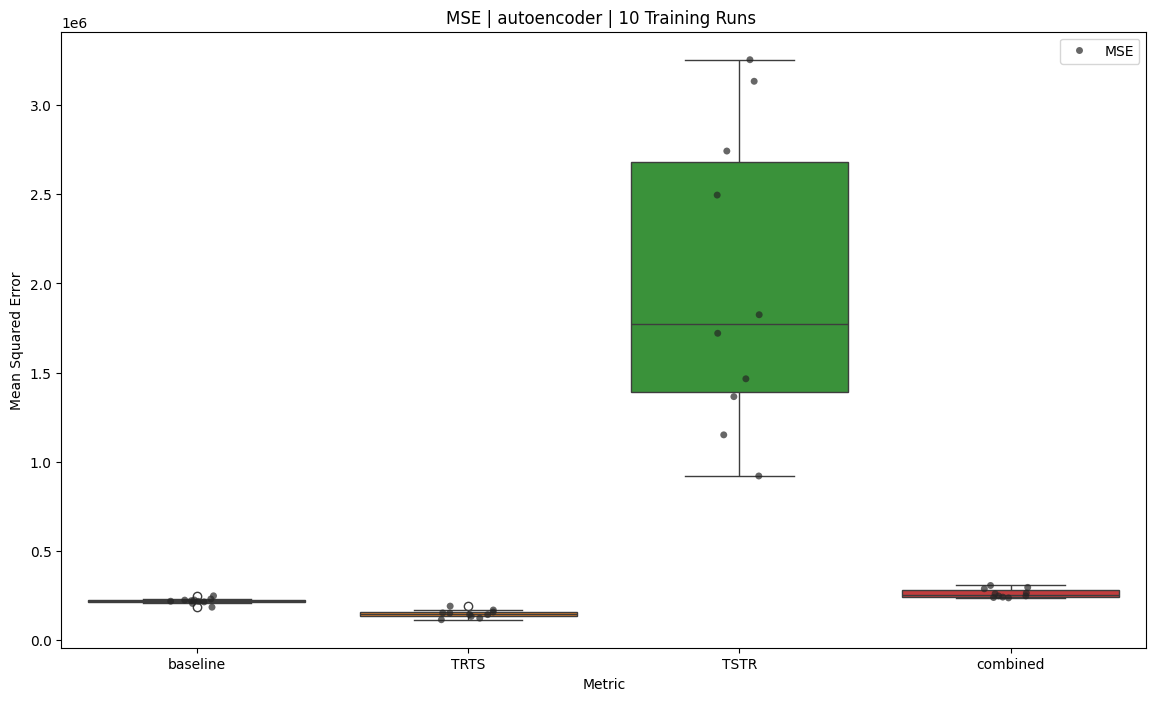

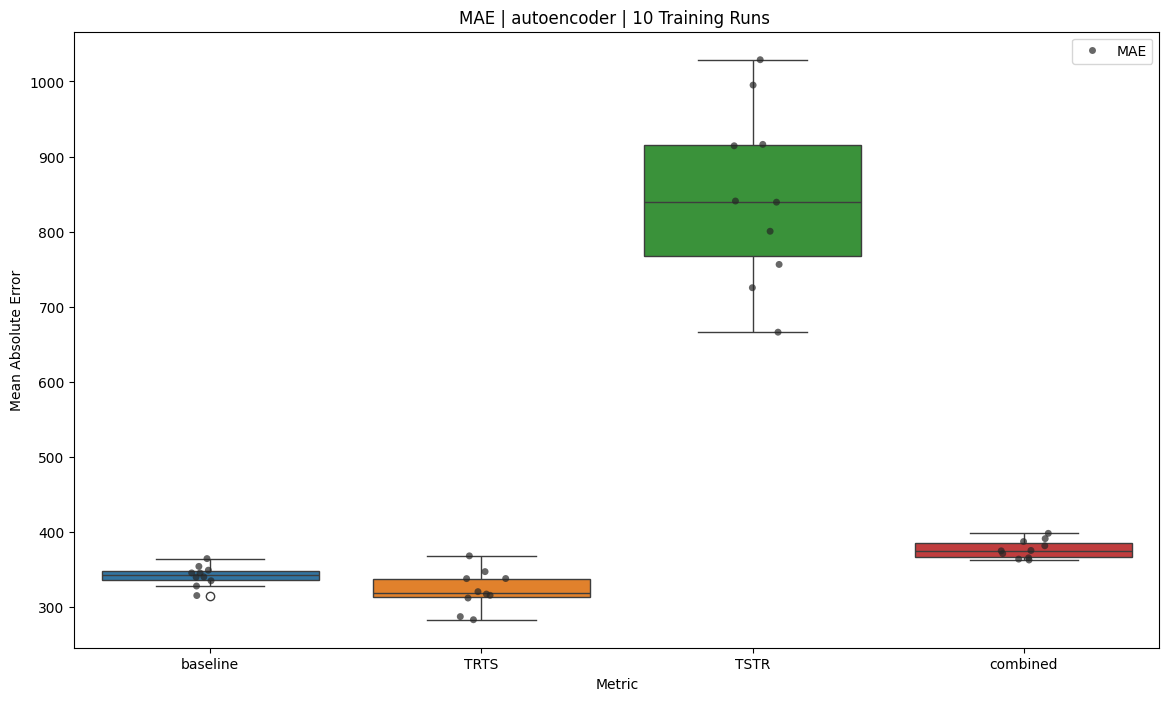

In [13]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

## 3 Evaluate Similarity of Synthetic vs Real Data

## 4 Visualize Synthetic vs Real Data

In [14]:
# split data before feeding into visual evaluation
data_real_seq = split_data_into_sequences(data_real_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

if data_syn_numpy.ndim == 3:
    data_syn_seq = data_syn_numpy
else:
    data_syn_seq = split_data_into_sequences(data_syn_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

Shape of the data after splitting into sequences: (28500, 12, 5)


Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)


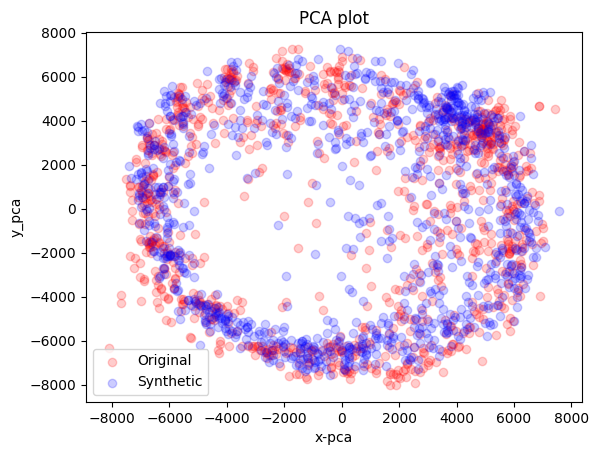

Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.087s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000


c:\Users\fanny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 946.454922
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.231922
[t-SNE] KL divergence after 300 iterations: 1.035306


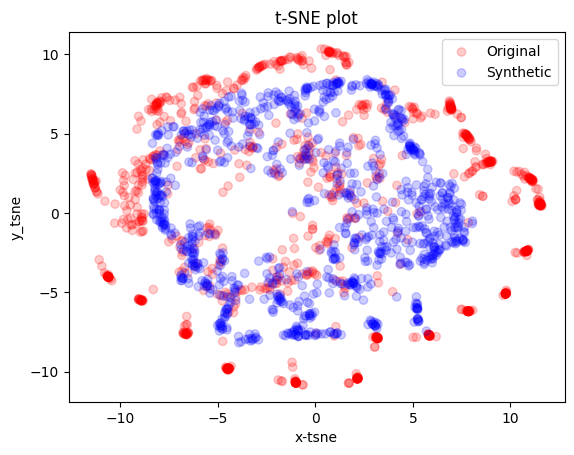

In [15]:
visualize(data_real_seq, data_syn_seq, metric='pca')
visualize(data_real_seq, data_syn_seq, metric='tsne')

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.